In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision.models import vgg16
from PIL import Image
%matplotlib inline

Q1 - Loading the model

In [2]:
model = vgg16(pretrained=True, progress=True)
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\yuval/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Q2 - 2 Images

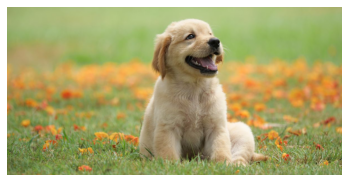

In [3]:
dog = cv2.imread('my_data/dog.jpg')
plt.imshow(cv2.cvtColor(dog, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

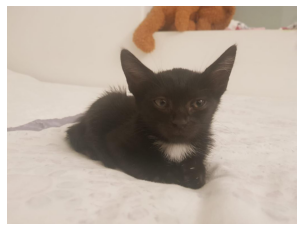

In [88]:
soda = cv2.imread('my_data/soda.jpeg')
plt.imshow(cv2.cvtColor(soda, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

Q3 - Pre-Processing the images

In [5]:
dog_tensor = preprocess(dog).unsqueeze(0).to(device)
soda_tensor = preprocess(soda).unsqueeze(0).to(device)

Q4 - Forward pass

In [6]:
with torch.no_grad():
    output_dog = model(dog_tensor)[0].argmax()
    output_soda = model(soda_tensor)[0].argmax()

import ast
text = open("data/imagenet1000_clsidx_to_labels.txt","r").read()
classes = ast.literal_eval(text)

print(classes[output_dog.item()])
print(classes[output_soda.item()])

Arctic fox, white fox, Alopex lagopus
Pomeranian


Q5 - segmentation

background
cat
dog
sheep


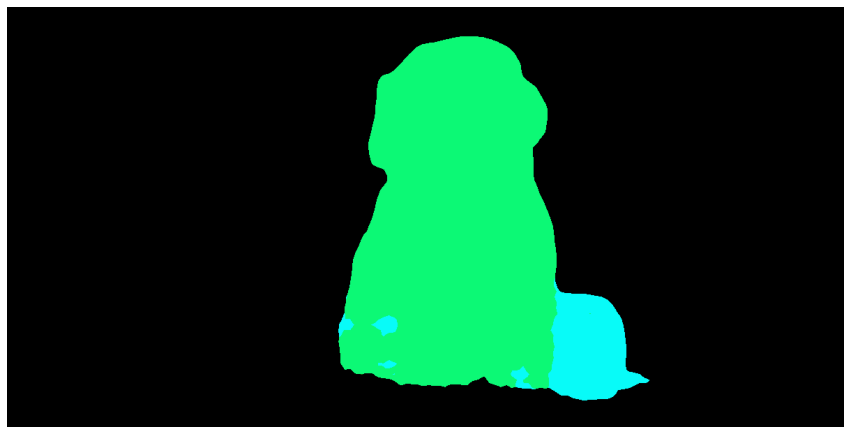

In [7]:
from torchvision.models.segmentation import fcn_resnet50

dog2 = Image.open('my_data/dog.jpg')

dog2_tensor = preprocess(dog2).unsqueeze(0).to(device)

seg_model = fcn_resnet50(pretrained=True)
seg_model.eval()

seg_model.to(device)

with torch.no_grad():
    output = seg_model(dog2_tensor)['out'][0]

output_predictions = output.argmax(0)

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(dog2.size)
r.putpalette(colors)

# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(r)
ax.set_axis_off()

labels = ['background', 'aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
        'bus',        'car',      'cat',  'chair',     'cow',
        'diningtable','dog',    'horse',  'motorbike', 'person',
        'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

# what labels were recognized?
for label in np.unique(output_predictions.cpu().numpy()):
    print(labels[label])

Q6 - Different background

True

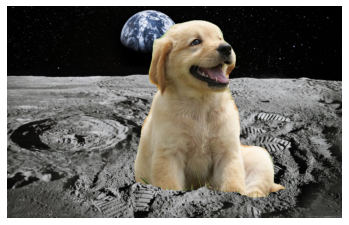

In [32]:
# cutting_dog = cv2.imread("my_data/dog.jpg", -1)
mask = torch.zeros_like(output_predictions).float().to(device)
mask[output_predictions != 0] = 1
masked_dog = dog * mask.unsqueeze(2).byte().cpu().numpy()
masked_dog = masked_dog[:, 200:1000, :]

x_offset = 100
y_offset = 0

moon = cv2.imread('data/moon.jpg')

np.copyto(moon[y_offset:y_offset+masked_dog.shape[0], x_offset:x_offset+masked_dog.shape[1]], masked_dog, where=masked_dog[:,:]!=0)

plt.imshow(cv2.cvtColor(moon, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

cv2.imwrite("../output/moon_dog.jpg", moon)

Q7 - classify with different background

In [ ]:
dog_moon_tensor = preprocess(moon).unsqueeze(0).to(device)

with torch.no_grad():
    output_dog_moon = model(dog_moon_tensor)[0].argmax()

print(classes[output_dog_moon.item()])

In [41]:
def plot_filters_multi_channel(t):

    # get the number of kernals
    num_kernels = t.shape[0]

    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels

    # set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))

    # looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)

        # for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

#     plt.savefig('myimage.png', dpi=100)
    plt.tight_layout()

Q8 - Visualizing the filters

torch.Size([3, 3, 3, 3])


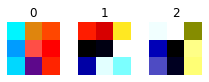

In [43]:
first_layer = model.features[0]
weight_tensor =first_layer.weight.data[0:3, :, :, :].cpu()
print(weight_tensor[0:3, :, :, :].shape)

plot_filters_multi_channel(weight_tensor)

In [49]:
with torch.no_grad():
    first_layer_response = first_layer(dog_tensor).squeeze(0)[0:3, :, :].cpu()
print(first_layer_response.shape)

torch.Size([3, 602, 1200])


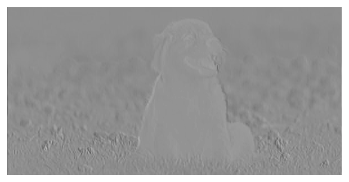

In [50]:
plt.imshow(first_layer_response[0, :, :], cmap='gray')
_ = plt.axis('off')

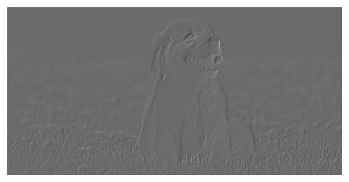

In [52]:
plt.imshow(first_layer_response[1, :, :], cmap='gray')
_ = plt.axis('off')

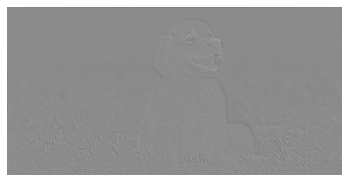

In [53]:
plt.imshow(first_layer_response[2, :, :], cmap='gray')
_ = plt.axis('off')

In [54]:
with torch.no_grad():
    first_layer_response = first_layer(dog_moon_tensor).squeeze(0)[0:3, :, :].cpu()
print(first_layer_response.shape)

torch.Size([3, 624, 988])


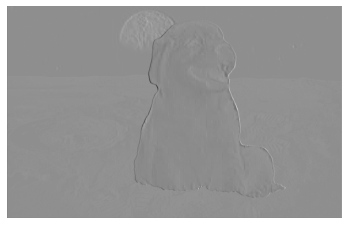

In [55]:
plt.imshow(first_layer_response[0, :, :], cmap='gray')
_ = plt.axis('off')

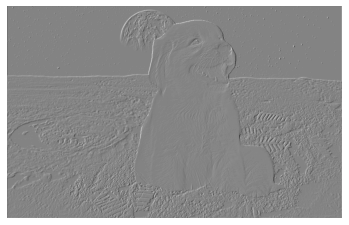

In [56]:
plt.imshow(first_layer_response[1, :, :], cmap='gray')
_ = plt.axis('off')

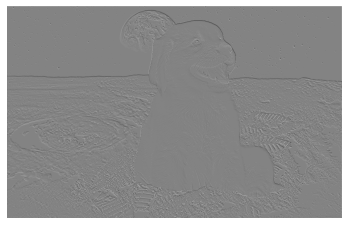

In [57]:
plt.imshow(first_layer_response[2, :, :], cmap='gray')
_ = plt.axis('off')

Q10

In [73]:
def extract_features(image_tensor):
    with torch.no_grad():
        output = model.features(image_tensor)
        output = model.avgpool(output)
        output = model.classifier[0](output.view(output.size(0), -1))
    return output

In [75]:
import glob
cats_features = []
for cat in glob.glob("data/cats/*.jpg"):
    cat_tensor = preprocess(cv2.imread(cat)).unsqueeze(0).to(device)
    cat_features = extract_features(cat_tensor)
    cats_features.append(cat_features.cpu().numpy())

dogs_features = []
for dog in glob.glob("data/dogs/*.jpg"):
    dog_tensor = preprocess(cv2.imread(dog)).unsqueeze(0).to(device)
    dog_features = extract_features(dog_tensor)
    dogs_features.append(dog_features.cpu().numpy())


Q11

In [77]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

x_train = np.concatenate(cats_features + dogs_features)
y_train = np.array([0]*len(cats_features) + [1]*len(dogs_features))

svm.fit(x_train, y_train)

LinearSVC()

In [85]:
test_dog1 = preprocess(cv2.imread("my_data/test_dog1.jpg")).unsqueeze(0).to(device)
test_dog2 = preprocess(cv2.imread("my_data/test_dog2.jpg")).unsqueeze(0).to(device)

test_cat1 = preprocess(cv2.imread("my_data/shmoot.jpg")).unsqueeze(0).to(device)
test_cat2 = preprocess(cv2.imread("my_data/soda.jpeg")).unsqueeze(0).to(device)

In [86]:
def classify(im):
    prediction = svm.predict(extract_features(im).cpu().numpy())
    if prediction == 1:
        return "dog"
    else:
        return "cat"

In [87]:
print("first dog prediction", classify(test_dog1))
print("second dog prediction", classify(test_dog2))
print("first cat prediction", classify(test_cat1))
print("second cat prediction", classify(test_cat2))

first dog prediction dog
second dog prediction dog
first cat prediction cat
second cat prediction cat
